### Парсинг данных и создание датафрейма

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

# %matplotlib notebook

In [2]:
paths = glob.glob(f"build/*ParticleData_t*.csv")

In [3]:
# Вытаскиваем из первого файла названия столбцов
with open(paths[0], 'r') as f:
    lines = []
    while True:
        line = f.readline()
        if line[0] != '#':
            break
        lines.append(line)
    title = lines[1].replace('#title ', '')[:-1]                        # переделать через regex
    sep = chr(int(lines[2].replace('#separator ', '')[:-1]))            # переделать через regex
    vsc_sep = chr(int(lines[3].replace('#vector_separator ', '')[:-1])) # переделать через regex
    columns = [' '.join(i.split(' ')[2:])[:-1] for i in lines[4:]]
    metarows_len = len(lines)

In [4]:
data = pd.DataFrame()
for path in paths:
    item = pd.read_csv(path, skiprows=metarows_len, names=columns)
    data = data.append(item, ignore_index=True)

In [5]:
data

,particle_name,X,Y,Z,vX,vY,vZ,energy
0,e-,-133.04500,81.0331,-36.06310,-0.414359,0.253746,-0.110604,0.202747
1,e-,111.50000,112.5720,-21.52500,0.416829,0.410675,-0.090500,0.271120
2,e-,-60.53540,114.5360,-93.72830,-0.228808,0.411783,-0.352593,0.268335
3,e-,62.94150,-63.2695,-132.67800,0.234554,-0.223248,-0.479264,0.260797
4,e-,-7.08991,116.7700,-109.00700,-0.030055,0.419751,-0.388199,0.256408
...,...,...,...,...,...,...,...,...
4125036,e-,-85.80890,129.5020,-37.86990,-0.308441,0.457587,-0.142497,0.254473
4125037,e-,77.61730,139.7870,-1.79295,0.261473,0.466322,-0.008007,0.228601
4125038,e-,-22.18330,145.7970,61.79990,-0.070620,0.513578,0.214842,0.247965
4125039,e-,-86.00890,71.7960,-114.08700,-0.293367,0.256716,-0.397313,0.244610


In [6]:
set(data["particle_name"])

{'e-', 'gamma'}

In [7]:
len(data[data["particle_name"]=="e-"])

4050414

In [8]:
len(data[data["particle_name"]=="gamma"])

74627

### Преобразование к полярным координатам

In [9]:
xyz_e = data[data["particle_name"]=="gamma"][["X", "Y", "Z"]]

In [87]:
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    return az, el, r

def pol2cart(rho, theta, phi):
    x = rho * np.sin(theta) * np.cos(phi)
    y = rho * np.sin(theta) * np.sin(phi)
    z = rho *np.cos(theta)
    return(x, y, z)

In [11]:
df_pol = cart2sph(xyz_e["X"], xyz_e["Y"],xyz_e["Z"])

In [12]:
pol_phi_theta = np.array([df_pol[0].to_numpy(), df_pol[1].to_numpy()])

In [13]:
print(f"φ range: {min(pol_phi_theta[0])} to {max(pol_phi_theta[0])}")
print(f"θ range: {min(pol_phi_theta[1])} to {max(pol_phi_theta[1])}")

φ range: -3.1415390466607658 to 3.141411938121803
θ range: -1.567850984311136 to 1.224654557517799


### Выбор интересующей области

In [104]:

φ_from = np.pi/4 - np.pi/10
φ_to = np.pi/4 + np.pi/10

In [105]:
segment, out_segment = [], []
for phi, theta in pol_phi_theta.T:
    if φ_from<phi<φ_to:
        segment.append((theta, phi, 1))
    else:
        out_segment.append((theta,phi, 1))

In [106]:
xyz_segment = np.array([pol2cart(r, theta, phi) for theta, phi, r in segment]).T
xyz_out_segment = np.array([pol2cart(r, theta, phi) for theta, phi, r in out_segment]).T

<IPython.core.display.Javascript object>


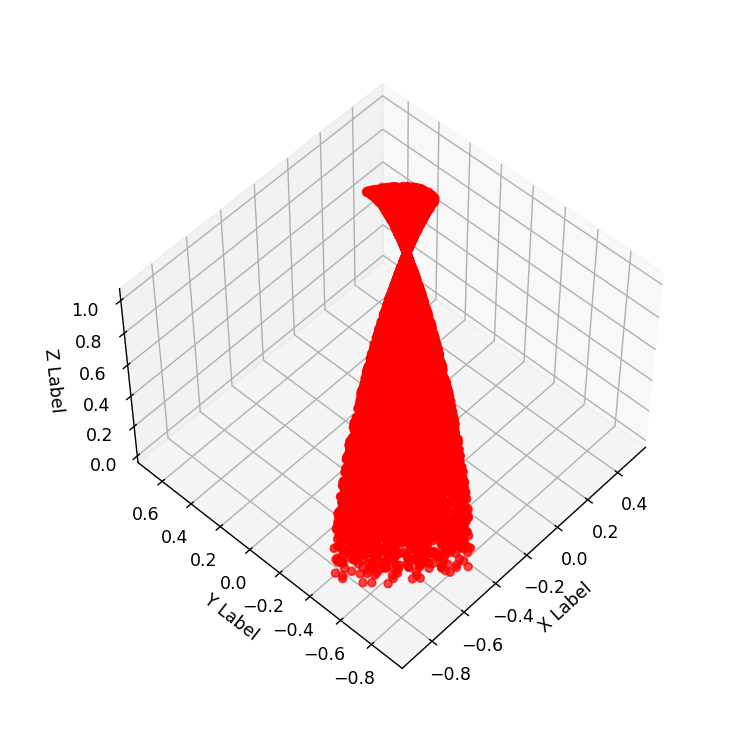

In [108]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz_segment[0],xyz_segment[1],xyz_segment[2], c="red")
# ax.scatter(xyz_out_segment[0],xyz_out_segment[1],xyz_out_segment[2], c="blue")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [109]:
segment_theta = np.array(segment).T[0]
hist = np.histogram(segment_theta, bins=100)
segment_theta.shape

(12495,)

In [110]:
theta = hist[1][:100]
radii = hist[0]

<IPython.core.display.Javascript object>


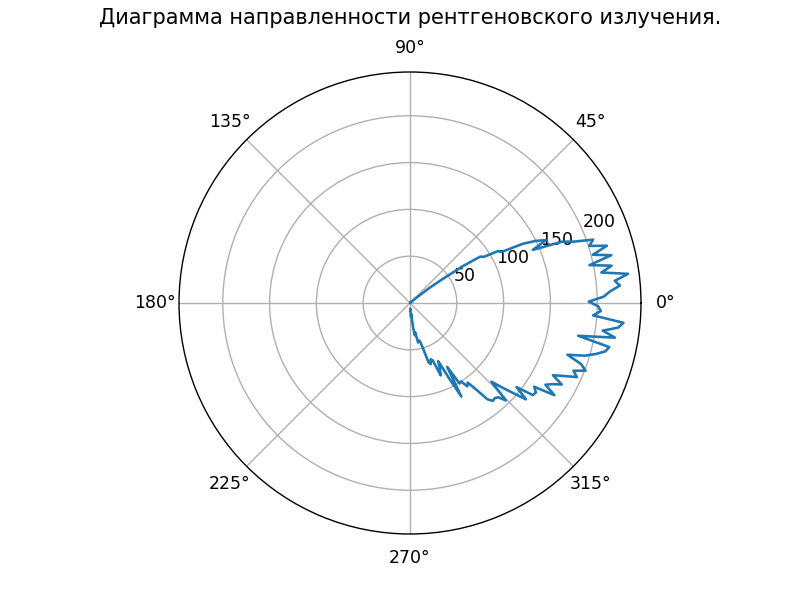

In [111]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, radii)
ax.set_title("Диаграмма направленности рентгеновского излучения.", va='bottom')
plt.show()